In [1]:
import os 
from tifffile import imread, imsave
import numpy as np
import matplotlib.pyplot as plt

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Config(change here)

In [2]:
from os import path

img_type = 'vas'                        # ['ast', 'vas', 'neu', 'smp']
test_img_path = 'test_images/VAS/raw/'
save_path = 'denoised/'
model_name = 'n2v'                      # ['care', 'n2v', 'n2n', 'dncnn', 'resnet', ...]

if not path.exists(save_path):
    os.mkdir(save_path)

### Load test images

In [3]:
def cut_off(img_, max_value):
    img = np.copy(img_)
    img = img.astype('float32')
    mask = img > max_value
    img[mask] = max_value
    img = img / max_value * 1.0
    return img

In [4]:
test_imgs = []
files = os.listdir(test_img_path)
for i, file in enumerate(files):
    print('loading ' + file)
    image = imread(test_img_path + file)
    max_value = np.percentile(image, 99.5)
    test_imgs.append(cut_off(image, max_value))
test_imgs = np.stack(test_imgs)
print('done')

loading VAS_002_McCoy_1200nm_ch1_25x_Z6_THG.tif
loading VAS_010_McCoy_1200nm_ch1_25x_Z6_THG.tif
loading VAS_012_McCoy_1200nm_ch1_25x_Z6_THG.tif
loading VAS_017_McCoy_1200nm_ch3_25x_Z11_RFP.tif
loading VAS_020_McCoy_1200nm_ch1_25x_Z7_THG.tif
done


### Load models

In [5]:
from csbdeep.models import CARE
from n2v.models import N2V
from nets.dncnn import DnCNN
from nets.resnet import ResNet
import torch

model = None
if model_name == 'care':
    print('loading CARE.')
    model = CARE(config=None, name='care', basedir='models/models_{}/'.format(img_type))
if model_name == 'n2n':
    print('loading N2N')
    model = CARE(config=None, name='n2n', basedir='models/models_{}/'.format(img_type))
if model_name == 'n2v':
    print('loading N2V')
    model = N2V(config=None, name='n2v', basedir='models/models_{}/'.format(img_type))
if model_name == 'dncnn':
    print('loading DnCNN.')
    model = DnCNN(bias=False)
    model.load_state_dict(torch.load('models/models_{}/dncnn/dncnn.pt'.format(img_type), map_location=device))
    model.eval()
if model_name == 'resnet':
    print('loading ResNet.')
    model = ResNet()
    model.load_state_dict(torch.load('models/models_{}/resnet/resnet.pt'.format(img_type), map_location=device))
    model.eval()

Using TensorFlow backend.


loading N2V
Loading network weights from 'weights_best.h5'.


### Predict and save predicted images

In [6]:
if model_name in ['care', 'n2n', 'n2v']:
    imgs = test_imgs[...,np.newaxis]
    preds = model.keras_model.predict(imgs)[...,0]
if model_name in ['dncnn', 'resnet']:
    imgs = np.expand_dims(test_imgs, axis=1)
    imgs = torch.as_tensor(imgs.astype('float32'))
    preds = model(imgs).detach().numpy()[:,0,...]

for i,file in enumerate(files):
    imsave(save_path+file, preds[i])

### Visulization

Text(0.5, 1.0, 'prediction')

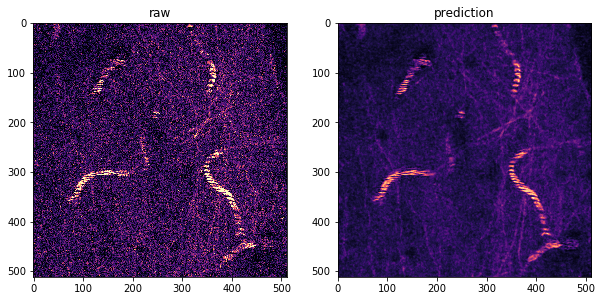

In [7]:
# direct visualization by comparing raw and prediction
filename = 'VAS_002_McCoy_1200nm_ch1_25x_Z6_THG.tif'     # can be changed here
cmap = 'magma'                                            # ['magma', 'gray', ...]

idx = files.index(filename)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(test_imgs[idx], cmap=cmap)
plt.title('raw')
plt.subplot(1,2,2)
plt.imshow(preds[idx], cmap=cmap)
plt.title('prediction')

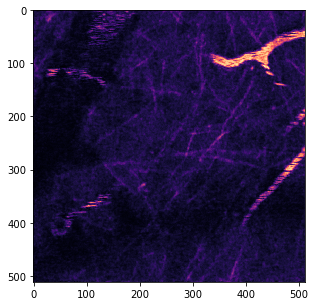

In [8]:
# visualize from saved predictions
filename = 'VAS_010_McCoy_1200nm_ch1_25x_Z6_THG.tif'        # can be changed here
cmap = 'magma'                                                # ['magma', gray', ...]

x = imread(save_path + filename)
plt.figure(figsize=(5,5))
plt.imshow(x, cmap=cmap)